# Power density spectrum

TODO:

- What is the unit of amplitude of the Reyes recording trace (mV or microVolt)?
- our is in mV (BlueConfig under lfp report)
- plot by channel and by layer 



### Setup

Activate `npx_10m_384ch_unit_classes` venv

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import scipy
import spikeinterface.extractors as se 
import os
import spikeinterface as si
import spikeinterface.preprocessing as spre

# SET PROJECT PATH
# PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/cns_2023_on_git/"

os.chdir(PROJ_PATH)

from src.nodes.utils import get_config

# SETUP NPX EXPERIMENT
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_02_19"
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()

# set channel
CHANNEL_ID = 0

# SETUP REAL REYES EXPERIMENT

DATA_PATH = "/gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/dataset/horvath/Rat01/Insertion1/Depth2/Rat01_Insertion1_Depth2.nwb"

# our model
RAW_RECORDING_PATH = data_conf["recording"]["output"]

2023-07-10 19:09:20,202 - root - utils.py - get_config - INFO - Reading experiment config.
2023-07-10 19:09:20,242 - root - utils.py - get_config - INFO - Reading experiment config. - done


In [53]:
def get_power_spectrum(recording, channel_id:int):

    # get recordig sampling frequency
    samp_freq = int(recording.get_sampling_frequency())

    # take n instances of 1 sec each
    # n_instances = np.floor(recording.get_total_duration())
    n_instances = 80 # 80 pieces

    # get all traces
    traces = recording.get_traces()    

    # split into n consecutive sequences
    sequences = np.array_split(traces[:, channel_id], n_instances)

    # record consecutive trace instances in a list
    psds = []
    fs = []
    for signal_i in sequences:
        (f, S) = scipy.signal.periodogram(signal_i, samp_freq, scaling='density') 
        psds.append(S)
        fs.append(f)

    psds = np.array(psds)
    fs = np.array(fs)
    return psds, fs

def plot_power_spectrum_stats(psds, fs, axes, color):
    
    # init figure
    if axes is None:
        fig, axes = plt.subplots(1,21,figsize=(7,3))
        
    # calculate stats over instances
    mean_psds = np.mean(psds, axis=0)
    ci = 1.96 * np.std(psds, axis=0) / np.sqrt(len(fs[0]))

    # Zoom in on the plot (same as range as Martinez, 2009, JNMethods)
    axes[1].plot(fs[0], mean_psds, color=color, linewidth=0.5, label="mean");

    # Plot the confidence interval
    axes[1].fill_between(fs[0], (mean_psds-ci), (mean_psds+ci), color=[.7, .7, .7], linewidth=1)

    # legend
    axes[1].set_title("zoom in")
    axes[1].set_xlim([-50, 3000]);
    axes[1].set_ylim([-5000, 1e5]);
    axes[1].set_xlabel("frequency (Hz)", fontsize=9);
    axes[1].set_ylabel("power spectrum density ($mV^2/Hz$)", fontsize=9);
    axes[1].spines[["right", "top"]].set_visible(False)
    # plt.legend();
    plt.tight_layout()
    return axes

### Real data (Horvath)

In [54]:
# takes 20 min
CHANNEL_ID = 10

# load
reyes_recording = se.NwbRecordingExtractor(DATA_PATH)

# preprocess (sampling frequency is 20,000 Hz)
reyes_recording_pre = spre.bandpass_filter(reyes_recording, freq_min=300, freq_max=6000)
reyes_recording_pre = spre.common_reference(reyes_recording_pre, reference='global', operator='median')

# calculate raw data power density spectrum for each splits of a channel trace
reyes_psds, reyes_fs = get_power_spectrum(reyes_recording, channel_id=CHANNEL_ID)

# calculate preprocessed data power density spectrum for each splits of a channel trace
reyes_pre_psds, reyes_pre_fs = get_power_spectrum(reyes_recording_pre, channel_id=CHANNEL_ID)

In [52]:
# # get recordig sampling frequency
# samp_freq = int(reyes_recording.get_sampling_frequency())

# # take n instances of 1 sec each
# # n_instances = np.floor(reyes_recording.get_total_duration())
# n_instances = 80 # 80 pieces

# # get all traces
# traces = reyes_recording.get_traces()    

# # split into n consecutive sequences
# sequences = np.array_split(traces[:, CHANNEL_ID], n_instances)

# # record consecutive trace instances in a list
# psds = []
# fs = []
# for signal_i in sequences:
#     (f, S) = scipy.signal.periodogram(signal_i, samp_freq, scaling='density') 
#     psds.append(S)
#     fs.append(f)

# psds = np.array(psds)
# fs = np.array(fs)

In [55]:
reyes_recording_pre

CommonReferenceRecording: 128 channels - 1 segments - 20.0kHz - 3688.668s

In [56]:
# sanity check preprocessing worked
reyes_recording_pre.is_filtered()

True

In [57]:
def plot_power_spectrum_stats(psds, psds_prep, freqs, color_raw, color_prep, ylim:list):

    # init plot
    _, axis = plt.subplots(1,1,figsize=(5,3))

    # calculate stats over instances
    mean_psds = np.mean(psds, axis=0)
    ci = 1.96 * np.std(psds, axis=0) / np.sqrt(len(freqs[0]))

    # zoom in on the plot (same as range as Martinez, 2009, JNMethods)
    axis.plot(freqs[0], mean_psds, color=color_raw, linewidth=0.5, label="raw traces");

    # plot the confidence interval
    axis.fill_between(freqs[0], (mean_psds-ci), (mean_psds+ci), color=[.7, .7, .7], linewidth=1)

    # legend
    axis.set_xlim([-50, 1520]);
    axis.set_ylim(ylim);
    axis.set_xlabel("frequency (Hz)", fontsize=9);
    axis.set_ylabel("power spectrum density ($mV^2/Hz$)", fontsize=9);
    axis.spines[["right", "top"]].set_visible(False)
    plt.tight_layout()

    # calculate stats over instances
    mean_psds = np.mean(psds_prep, axis=0)
    ci = 1.96 * np.std(psds_prep, axis=0) / np.sqrt(len(freqs[0]))

    # zoom in on the plot (same as range as Martinez, 2009, JNMethods)
    axis.plot(freqs[0], mean_psds, color=color_prep, linewidth=0.5, label="preprocessed traces");

    # plot the confidence interval
    axis.fill_between(freqs[0], (mean_psds-ci), (mean_psds+ci), color=[.7, .7, .7], linewidth=1)

    # axis.set_yscale("log")
    
    # legend
    axis.set_xlim([-50, 1520]);
    axis.set_ylim(ylim);
    axis.set_xlabel("frequency (Hz)", fontsize=9);
    axis.set_ylabel("power spectrum density ($mV^2/Hz$)", fontsize=9);
    axis.spines[["right", "top"]].set_visible(False)
    plt.legend(frameon=False);   
    plt.tight_layout()

Difference in amplitude might be because studies use different levels of signal amplification.

/tmp/ipykernel_53934/3103520081.py:43: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


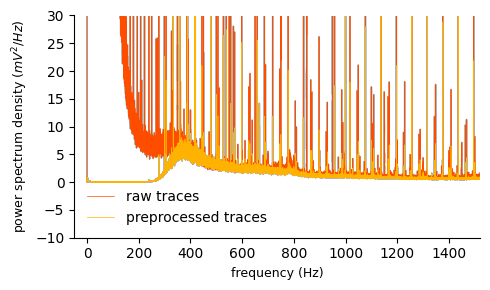

In [69]:
# reyes
assert all(reyes_fs[0] == reyes_pre_fs[0])
plot_power_spectrum_stats(reyes_psds, reyes_pre_psds, reyes_fs, color_raw=[1, 0.3, 0], color_prep=[1, 0.7, 0], ylim=[-10, 30])

plt.savefig("figures/power_horvath_real_data.pdf")